# Structure-Function Analysis
- Related to Figure 7.
- Visual response is correlated with connectivity.

In [1]:
import numpy as np
import pandas as pd
import pickle

import datajoint as dj

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, percentileofscore

from lib.utils import *
from lib.datajoint import *
from lib.calcium import *
from lib.plot import *

%matplotlib inline

## Connect to DataJoint database
- You need to be registered to access the database. Please register [here](https://forms.gle/6SeDGRT8zoLqpbfU9).
- For more information, refer to [README](https://github.com/seung-lab/MicronsBinder/blob/master/notebooks/multiscale/function/README.md) in the repository.
#### Currently, it is temporarily available without registration try running below cell.

In [3]:
# dj.config["database.host"] = "datajoint.ninai.org"
dj.config.load("dj_conf.json")
dj.conn()

pinky = dj.create_virtual_module("seung_pinky", "seung_pinky")

Connecting seung_guest@datajoint.ninai.org:3306


## All pyramidal cells (PyCs)
- 363 pyramidal cells that have soma inside the volume.

In [11]:
pinky.Neuron()

segmentation,segment_id,manual_id
185,648518346349491311,466
185,648518346349492130,499
185,648518346349492197,503
185,648518346349492682,163
185,648518346349493472,549
185,648518346349493487,552
185,648518346349493874,-1
185,648518346349494004,47
185,648518346349494577,462
185,648518346349496405,174


In [4]:
key = {"segmentation": 185}
pyc_list = (pinky.Neuron() & key).fetch("segment_id")
n_pyc = pyc_list.shape[0]

## PyCs with functional data

In [5]:
pinky.EASETuning()

scan_id,segmentation,segment_id,manual_id,tune_curve,osi,osi_p,dsi,dsi_p
1,185,648518346349492682,163,=BLOB=,0.121011,0.5419,0.146072,0.408
1,185,648518346349522230,299,=BLOB=,0.369041,0.0076,0.352773,0.0137
1,185,648518346349524063,359,=BLOB=,0.422592,0.0691,0.411033,0.0989
1,185,648518346349524141,373,=BLOB=,0.0355879,0.7989,0.0699038,0.3676
1,185,648518346349532006,4,=BLOB=,0.52888,0.0,0.352457,0.0499
1,185,648518346349534048,393,=BLOB=,0.294242,0.4675,0.282311,0.5334
1,185,648518346349534072,112,=BLOB=,0.0723827,0.7697,0.0652564,0.8107
1,185,648518346349534580,94,=BLOB=,0.0511834,0.3319,0.0497808,0.3393
1,185,648518346349534945,471,=BLOB=,0.370999,0.0,0.202172,0.0
1,185,648518346349537153,38,=BLOB=,0.333346,0.0307,0.2339,0.2073


In [5]:
tune_info = pd.DataFrame(pinky.EASETuning())
pyc_func_list = np.array(tune_info["segment_id"])
scan_list = np.array(tune_info["scan_id"])
n_func = pyc_func_list.shape[0]

osi_p = np.array(tune_info["osi_p"])
dsi_p = np.array(tune_info["dsi_p"])

tune_idx = osi_p<0.01

## Soma center coordinates

#### All PyCs

In [5]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    pyc_soma_loc[i,:] = get_soma_loc(pinky, seg_id)

#### PyCs with functional data

In [6]:
pyc_func_soma_loc = np.zeros((n_func, 3))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    idx = np.where(pyc_list==seg_id)[0][0]
    pyc_func_soma_loc[i,:] = pyc_soma_loc[idx,:]

## Compute in-connection density

In [6]:
# In/out degree
# Computing only for cells with functional data
insyn_density = np.zeros((n_func)) # In-synapse density
inconn_density = np.zeros((n_func)) # In-connection density
outsyn_density = np.zeros((n_func)) # Out-synapse density
outconn_density = np.zeros((n_func)) # Out-connection density
total_insyn_density = np.zeros((n_func)) # Total in-synapse density

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    
    key = {"segment_id": seg_id}
    outsyn_density[i] = (pinky.SynDensity() & key).fetch1("syn_out_dens")
    insyn_density[i] = (pinky.SynDensity() & key).fetch1("syn_in_dens")
    
    outconn_density[i] = (pinky.SynDensity() & key).fetch1("conn_out_dens")
    inconn_density[i] = (pinky.SynDensity() & key).fetch1("conn_in_dens")
    
    total_insyn_density[i] = (pinky.SynDensity() & key).fetch1("total_syn_in_deg")

## Response strength

In [7]:
mean_response = np.zeros(n_func)
mean_active_response = np.zeros(n_func)
response_arrays = dict()
active_arrays = dict()

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace = get_trace(pinky, seg_id, scan_id, "trace_raw")
    stimlab = get_stim_label(pinky, scan_id)
    if dsi_p[pyc_func_list==seg_id]<0.01:
        cell_type = "ds"
    else:
        cell_type = "os"
        
    mean_response[i] = compute_response_strength(trace, stimlab, cell_type)

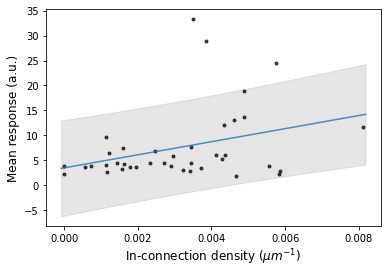

r = 0.33225210401435834, p = 0.038779237378214385


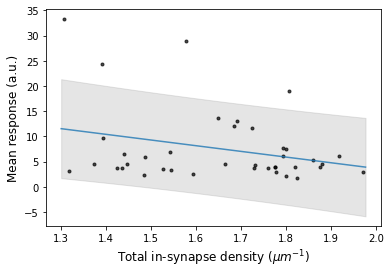

r = -0.28454053268974727, p = 0.07915080854328033


In [8]:
plot_linear_fit(inconn_density[tune_idx], mean_response[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="Mean response (a.u.)")

plot_linear_fit(total_insyn_density[tune_idx], mean_response[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="Mean response (a.u.)")

## Intermittency

In [17]:
intermittency = np.zeros(n_func)
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace = get_trace(pinky, seg_id, scan_id, "trace_raw")
    spike = get_trace(pinky, seg_id, scan_id, "spike")
    stimlab = get_stim_label(pinky, scan_id)
    
    response_array = get_peakamp_tdarray(trace, stimlab)
    tune = tuning_curve(response_array)
    dir_pref = np.argmax(tune)
    dir_opp = np.remainder(dir_pref+8, 16)
    
    if dsi_p[pyc_func_list==seg_id]<0.01:
        pref_idx = [dir_pref]
    else:
        pref_idx = [dir_pref, dir_opp]
    intermittency[i] = compute_intermittency(spike, stimlab, pref_idx, thr=3)

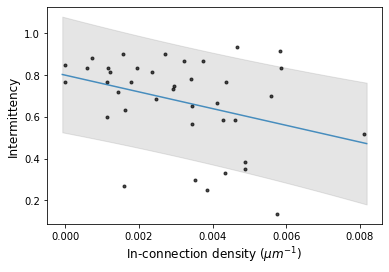

r = -0.34969536645458743, p = 0.02909389851886998


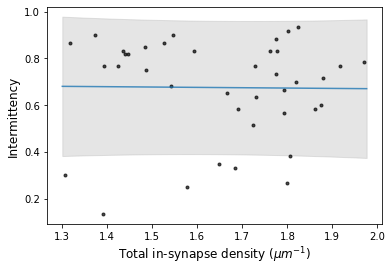

r = -0.012761752141055314, p = 0.938538280318435


In [19]:
plot_linear_fit(inconn_density[tune_idx], intermittency[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="Intermittency")

plot_linear_fit(total_insyn_density[tune_idx], intermittency[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="Intermittency")

## OSi / DSi

In [20]:
osi_list = np.zeros(n_func)
dsi_list = np.zeros(n_func)

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    
    key = {"segment_id": seg_id}
    osi_list[i] = (pinky.EASETuning() & key).fetch1("osi")
    dsi_list[i] = (pinky.EASETuning() & key).fetch1("dsi")

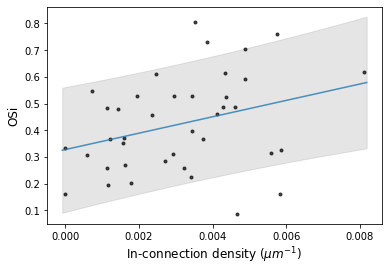

r = 0.3203093978999877, p = 0.04681465098147745


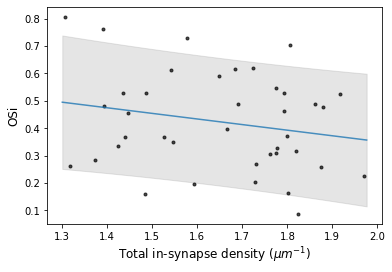

r = -0.21177408252478142, p = 0.19558354888129867


In [23]:
plot_linear_fit(inconn_density[tune_idx], osi_list[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="OSi")

plot_linear_fit(total_insyn_density[tune_idx], osi_list[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="OSi")

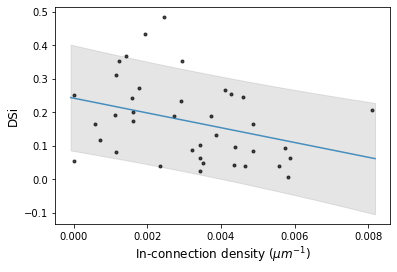

r = -0.33907483947239997, p = 0.03471796566623156


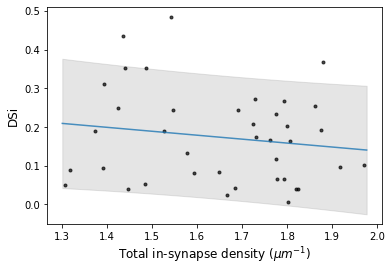

r = -0.15552821029638794, p = 0.34443293818390136


In [25]:
plot_linear_fit(inconn_density[tune_idx], dsi_list[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="DSi")

plot_linear_fit(total_insyn_density[tune_idx], dsi_list[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="DSi")

## Spatial location restricted permutation test

In [26]:
xloc = pyc_func_soma_loc[tune_idx,0]
yloc = pyc_func_soma_loc[tune_idx,1]
zloc = pyc_func_soma_loc[tune_idx,2]

xbins = np.linspace(np.min(xloc), np.max(xloc)*1.001, 3); nx = xbins.shape[0]-1
ybins = np.linspace(np.min(yloc), np.max(yloc)*1.001, 5); ny = ybins.shape[0]-1
zbins = np.linspace(np.min(zloc), np.max(zloc)*1.001, 3); nz = zbins.shape[0]-1

val_density = inconn_density[tune_idx]
indices = np.arange(val_density.shape[0])

idx_list = []
density_list = []
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            
            valid = (xloc>=xbins[i])*(xloc<xbins[i+1]) \
                    *(yloc>=ybins[j])*(yloc<ybins[j+1]) \
                    *(zloc>=zbins[k])*(zloc<zbins[k+1])
            
            density_bin = val_density[valid]
            
            idx_list.append(indices[valid])
            density_list.append(density_bin)

### Mean response

In [27]:
xval = mean_response[tune_idx]
yval = inconn_density[tune_idx]

T = 10000
rand_resp = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_resp[t] = r

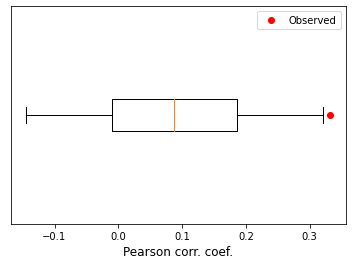

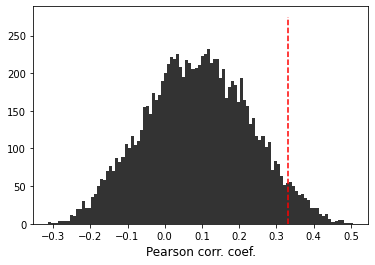

p = 0.042300000000000004


In [28]:
r_true_resp, p_true_resp = pearsonr(inconn_density[tune_idx], mean_response[tune_idx])

plt.figure()
plt.boxplot(rand_resp, sym="", whis=[5,95], vert=False)
plt.plot(r_true_resp, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_resp, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_resp, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(1-percentileofscore(rand_resp, r_true_resp)/100))

### Intermittency

In [29]:
xval = intermittency[tune_idx]
yval = inconn_density[tune_idx]

T = 10000
rand_int = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_int[t] = r

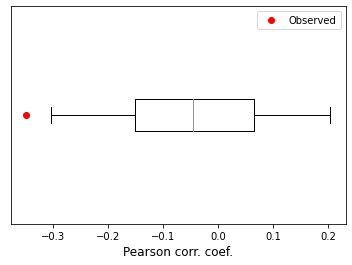

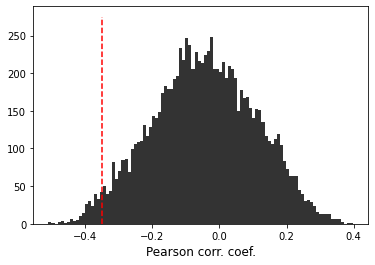

p = 0.0232


In [30]:
r_true_int, p_true_int = pearsonr(inconn_density[tune_idx], intermittency[tune_idx])

plt.figure()
plt.boxplot(rand_int, sym="", whis=[5,95], vert=False)
plt.plot(r_true_int, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_int, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_int, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(percentileofscore(rand_int, r_true_int)/100))

In [31]:
xval = osi_list[tune_idx]
yval = inconn_density[tune_idx]

T = 10000
rand_int = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_int[t] = r

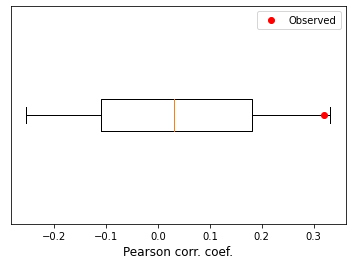

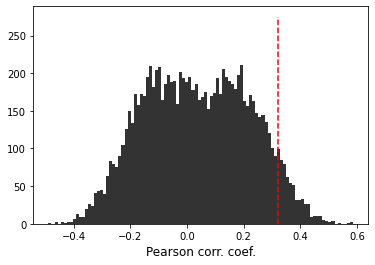

p = 0.042300000000000004


In [33]:
r_true_int, p_true_int = pearsonr(inconn_density[tune_idx], osi_list[tune_idx])

plt.figure()
plt.boxplot(rand_int, sym="", whis=[5,95], vert=False)
plt.plot(r_true_int, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_int, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_int, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(1-percentileofscore(rand_resp, r_true_resp)/100))